# Normalizing flows with MNIST a simple implementation of the Glow paper

This notebook trains model within ~1-2 hours.

In [1]:
import numpy as np
import tensorflow as tf
from scipy.stats import norm
import matplotlib.pyplot as plt

%matplotlib inline
%load_ext autoreload
%autoreload 2

## Import dataset

In [2]:
import tensorflow as tf
mnist = tf.keras.datasets.mnist

(x_train, y_train),(x_test, y_test) = mnist.load_data()
x_train, x_test = x_train / 255.0, x_test / 255.0

x_train.shape, x_test.shape, y_train.shape, y_test.shape

((60000, 28, 28), (10000, 28, 28), (60000,), (10000,))

### Convert dataset to the tf.data.Dataset

In [3]:
import utils
import nets
import flow_layers as fl

In [4]:
batch_size = 32
train_dataset = utils.numpy_array_to_dataset(array=x_train, batch_size=batch_size)

In [5]:
x_train_samples = train_dataset.make_one_shot_iterator().get_next()

In [6]:
x_train_samples = tf.reshape(x_train_samples, [batch_size, 28, 28, 1])
x_train_samples = tf.image.resize_bilinear(x_train_samples, size=(24, 24))
x_train_samples

<tf.Tensor 'ResizeBilinear:0' shape=(32, 24, 24, 1) dtype=float32>

In [7]:
tf.set_random_seed(0)
sess = tf.InteractiveSession()

### Check shapes

In [8]:
x_train_samples.eval().shape, x_train_samples.eval().max()

((32, 24, 24, 1), 1.0)

## Build Flow with Resnet blocks 

In [9]:
nn_template_fn = nets.ResentTemplate(
    units_factor=6, num_blocks=3
)

* the more steps the better. At the begining I have tried with num_steps=1, or 2 but model was not learning at all

In [10]:
layers, actnorm_layers = nets.create_simple_flow(
    num_steps=5, 
    num_scales=3, 
    template_fn=nn_template_fn
)
# create model
images = x_train_samples
flow = fl.InputLayer(images)
model_flow = fl.ChainLayer(layers)
output_flow = model_flow(flow, forward=True)

LogitifyImage/Forward/                  : x=[32, 24, 24, 1]	z=[None]	logdet=[32]
SqueezingLayer/Forward/Scale1           : x=[32, 12, 12, 4]	z=[None]	logdet=[32]
ActnormBiasLayer/Forward/               : x=[32, 12, 12, 4]	z=[None]	logdet=[32]
ActnormScaleLayer/Forward/              : x=[32, 12, 12, 4]	z=[None]	logdet=[32]
ChainLayer/Forward/                     : x=[32, 12, 12, 4]	z=[None]	logdet=[32]
ActnormLayer/Forward/                   : x=[32, 12, 12, 4]	z=[None]	logdet=[32]
InvertibleConv1x1Layer/Forward/         : x=[32, 12, 12, 4]	z=[None]	logdet=[32]
AffineCouplingLayer/Forward/            : x=[32, 12, 12, 4]	z=[None]	logdet=[32]
ChainLayer/Forward/Step1                : x=[32, 12, 12, 4]	z=[None]	logdet=[32]
ActnormBiasLayer/Forward/               : x=[32, 12, 12, 4]	z=[None]	logdet=[32]
ActnormScaleLayer/Forward/              : x=[32, 12, 12, 4]	z=[None]	logdet=[32]
ChainLayer/Forward/                     : x=[32, 12, 12, 4]	z=[None]	logdet=[32]
ActnormLayer/Forward/       

## Prepare output tensors

In [11]:
y, logdet, z = output_flow
output_flow

(<tf.Tensor 'ChainLayer/outputs/x:0' shape=(32, 3, 3, 8) dtype=float32>,
 <tf.Tensor 'ChainLayer/outputs/lodget:0' shape=(32,) dtype=float32>,
 <tf.Tensor 'ChainLayer/outputs/z:0' shape=(32, 3, 3, 56) dtype=float32>)

## Build loss function and prior distributions for p(y) and p(z)

* Here simply the $-logp(x)$

In [ ]:
tfd = tf.contrib.distributions

beta_ph = tf.placeholder(tf.float32, [])

y_flatten = tf.reshape(y, [batch_size, -1])
z_flatten = tf.reshape(z, [batch_size, -1])

prior_y = tfd.MultivariateNormalDiag(loc=tf.zeros_like(y_flatten), scale_diag=beta_ph * tf.ones_like(y_flatten))
prior_z = tfd.MultivariateNormalDiag(loc=tf.zeros_like(z_flatten), scale_diag=beta_ph * tf.ones_like(z_flatten))

log_prob_y =  prior_y.log_prob(y_flatten)
log_prob_z =  prior_z.log_prob(z_flatten)

In [13]:
prior_z

<tf.distributions.MultivariateNormalDiag 'MultivariateNormalDiag' batch_shape=(32,) event_shape=(504,) dtype=float32>

### The MLE loss

In [14]:
loss = log_prob_y + log_prob_z + logdet
loss = - tf.reduce_mean(loss)

### The L2 regularization loss 

In [15]:
trainable_variables = tf.trainable_variables() 
l2_reg = 0.001 
l2_loss = l2_reg * tf.add_n([ tf.nn.l2_loss(v) for v in trainable_variables])

### Debug model, print variables 

In [ ]:
total_params = 0
for k, v in enumerate(trainable_variables):
    num_params = np.prod(v.shape.as_list())
    total_params += num_params
    print(f"[{k:4}][{num_params:6}] {v.op.name[:96]}")

print(f"total_params: {total_params}")

### Total loss -logp(x) + l2_loss

In [17]:
sess.run(tf.global_variables_initializer())

In [18]:
total_loss = l2_loss + loss

In [19]:
l2_loss.eval(feed_dict={beta_ph: 1.0}), loss.eval(feed_dict={beta_ph: 1.0})

(1.2381905, 7343.073)

## Create backward flow to generate samples

In [20]:
sample_y_flatten = prior_y.sample()
sample_y = tf.reshape(sample_y_flatten, y.shape.as_list())
sample_z = tf.reshape(prior_z.sample(), z.shape.as_list())
sampled_logdet = prior_y.log_prob(sample_y_flatten)

In [21]:
inverse_flow = sample_y, sampled_logdet, sample_z
sampled_flow = model_flow(inverse_flow, forward=False)

FactorOutLayer/Backward/Scale3          : y=[32, 3, 3, 16]	z=[32, 3, 3, 48]	logdet=[32]
AffineCouplingLayer/Backward/           : y=[32, 3, 3, 16]	z=[32, 3, 3, 48]	logdet=[32]
InvertibleConv1x1Layer/Backward/        : y=[32, 3, 3, 16]	z=[32, 3, 3, 48]	logdet=[32]
ActnormScaleLayer/Backward/             : y=[32, 3, 3, 16]	z=[32, 3, 3, 48]	logdet=[32]
ActnormBiasLayer/Backward/              : y=[32, 3, 3, 16]	z=[32, 3, 3, 48]	logdet=[32]
ChainLayer/Backward/                    : y=[32, 3, 3, 16]	z=[32, 3, 3, 48]	logdet=[32]
ActnormLayer/Backward/                  : y=[32, 3, 3, 16]	z=[32, 3, 3, 48]	logdet=[32]
ChainLayer/Backward/Step5               : y=[32, 3, 3, 16]	z=[32, 3, 3, 48]	logdet=[32]
AffineCouplingLayer/Backward/           : y=[32, 3, 3, 16]	z=[32, 3, 3, 48]	logdet=[32]
InvertibleConv1x1Layer/Backward/        : y=[32, 3, 3, 16]	z=[32, 3, 3, 48]	logdet=[32]
ActnormScaleLayer/Backward/             : y=[32, 3, 3, 16]	z=[32, 3, 3, 48]	logdet=[32]
ActnormBiasLayer/Backward/      

In [22]:
x_flow_sampled, _, _ = sampled_flow

In [23]:
x_flow_sampled.eval({beta_ph: 1.0}).shape

(32, 24, 24, 1)

## Define optimizer and learning rate

In [ ]:
lr_ph = tf.placeholder(tf.float32)

optimizer = tf.train.AdamOptimizer(lr_ph)
train_op = optimizer.minimize(total_loss)

## Initialize Actnorms using DDI

Initialize actnorms with data dependent initialization, check paper for more details.

In [25]:
sess.run(tf.global_variables_initializer())
nets.initialize_actnorms(
    sess,
    feed_dict_fn=lambda: {beta_ph: 1.0},
    actnorm_layers=actnorm_layers,
    num_steps=50,
)

100%|██████████| 15/15 [00:38<00:00,  2.55s/it]


## Train model, define metrics and trainer

In [26]:
metrics = utils.Metrics(100, metrics_tensors={"total_loss": total_loss, "loss": loss, "l2_loss": l2_loss})
plot_metrics_hook = utils.PlotMetricsHook(metrics, step=1000)

In [27]:
sess.run(train_op, feed_dict={lr_ph: 0.0, beta_ph: 1.0})

In [28]:
total_loss.eval(feed_dict={lr_ph: 0.0, beta_ph: 1.0})

-1941.7601

### Initial samples from model

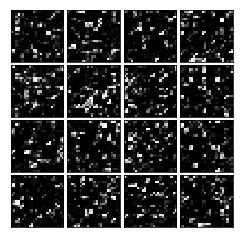

In [29]:
x_samples_np = x_flow_sampled.eval(feed_dict={lr_ph: 0.0, beta_ph: 1.0})
utils.plot_4x4_grid(x_samples_np, shape=x_samples_np.shape[1:3])

### Train model with lr=0.005

  1%|          | 101/10000 [00:11<19:01,  8.67it/s]

total_loss -2321.7607
loss -2322.9097
l2_loss 1.1488085


  2%|▏         | 201/10000 [00:21<17:52,  9.14it/s]

total_loss -2357.0356
loss -2358.1455
l2_loss 1.1099392


  3%|▎         | 302/10000 [00:32<17:27,  9.25it/s]

total_loss -2364.6611
loss -2365.7988
l2_loss 1.1375766


  4%|▍         | 401/10000 [00:43<17:09,  9.32it/s]

total_loss -2423.1592
loss -2424.3596
l2_loss 1.2004799


  5%|▌         | 501/10000 [00:53<16:52,  9.38it/s]

total_loss -2389.6765
loss -2390.915
l2_loss 1.2385005


  6%|▌         | 601/10000 [01:03<16:38,  9.41it/s]

total_loss -2456.1528
loss -2457.436
l2_loss 1.2832134


  7%|▋         | 701/10000 [01:14<16:27,  9.42it/s]

total_loss -2415.2705
loss -2416.586
l2_loss 1.3154898


  8%|▊         | 801/10000 [01:24<16:14,  9.44it/s]

total_loss -2471.2324
loss -2472.5789
l2_loss 1.3464615


  9%|▉         | 901/10000 [01:35<16:02,  9.46it/s]

total_loss -2440.977
loss -2442.359
l2_loss 1.3819033


 10%|▉         | 999/10000 [01:45<15:50,  9.47it/s]

total_loss -2505.939
loss -2507.3423
l2_loss 1.403423


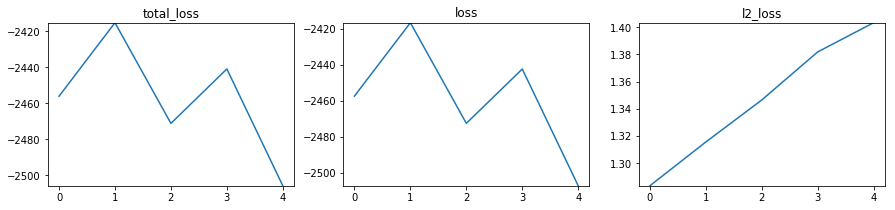

 11%|█         | 1102/10000 [01:56<15:41,  9.46it/s]

total_loss -2437.5525
loss -2438.9927
l2_loss 1.440077


 12%|█▏        | 1201/10000 [02:06<15:28,  9.47it/s]

total_loss -2415.6116
loss -2417.0632
l2_loss 1.4516027


 13%|█▎        | 1302/10000 [02:16<15:11,  9.55it/s]

total_loss -2377.5464
loss -2379.0024
l2_loss 1.4560666


 14%|█▍        | 1401/10000 [02:26<15:00,  9.55it/s]

total_loss -2495.0964
loss -2496.5823
l2_loss 1.4857941


 15%|█▌        | 1501/10000 [02:37<14:49,  9.56it/s]

total_loss -2460.6665
loss -2462.196
l2_loss 1.5294697


 16%|█▌        | 1602/10000 [02:47<14:37,  9.57it/s]

total_loss -2495.3115
loss -2496.853
l2_loss 1.5415387


 17%|█▋        | 1701/10000 [02:57<14:26,  9.57it/s]

total_loss -2487.496
loss -2489.0542
l2_loss 1.5581287


 18%|█▊        | 1801/10000 [03:08<14:16,  9.58it/s]

total_loss -2444.1042
loss -2445.6855
l2_loss 1.5812789


 19%|█▉        | 1902/10000 [03:18<14:05,  9.57it/s]

total_loss -2465.2107
loss -2466.8027
l2_loss 1.5921271


 20%|█▉        | 1999/10000 [03:28<13:54,  9.59it/s]

total_loss -2444.0007
loss -2445.605
l2_loss 1.6042808


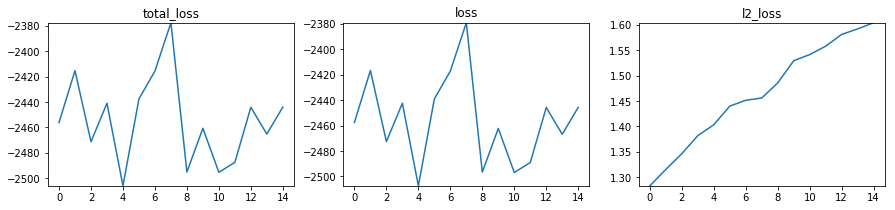

 21%|██        | 2101/10000 [03:39<13:45,  9.57it/s]

total_loss -2431.1372
loss -2432.745
l2_loss 1.6078644


 22%|██▏       | 2202/10000 [03:49<13:33,  9.58it/s]

total_loss -2438.6257
loss -2440.2605
l2_loss 1.6348859


 23%|██▎       | 2301/10000 [03:59<13:22,  9.59it/s]

total_loss -2492.2495
loss -2493.887
l2_loss 1.6375647


 24%|██▍       | 2400/10000 [04:10<13:12,  9.59it/s]

total_loss -2440.0203
loss -2441.6746
l2_loss 1.6541891


 25%|██▌       | 2502/10000 [04:20<13:01,  9.60it/s]

total_loss -2481.625
loss -2483.298
l2_loss 1.6731105


 26%|██▌       | 2601/10000 [04:30<12:50,  9.60it/s]

total_loss -2488.527
loss -2490.21
l2_loss 1.6828027


 27%|██▋       | 2701/10000 [04:41<12:40,  9.60it/s]

total_loss -2435.1177
loss -2436.8145
l2_loss 1.6967659


 28%|██▊       | 2800/10000 [04:51<12:29,  9.61it/s]

total_loss -2473.1892
loss -2474.8962
l2_loss 1.7070296


 29%|██▉       | 2901/10000 [05:01<12:18,  9.61it/s]

total_loss -2461.1497
loss -2462.8657
l2_loss 1.7159564


 30%|██▉       | 2999/10000 [05:11<12:07,  9.62it/s]

total_loss -2487.4487
loss -2489.1821
l2_loss 1.7334883


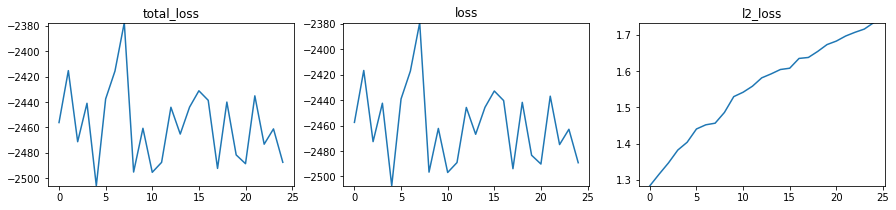

 31%|███       | 3101/10000 [05:22<11:57,  9.61it/s]

total_loss -2476.1943
loss -2477.9248
l2_loss 1.7305067


 32%|███▏      | 3202/10000 [05:33<11:47,  9.62it/s]

total_loss -2472.7126
loss -2474.4568
l2_loss 1.7440382


 33%|███▎      | 3300/10000 [05:43<11:36,  9.62it/s]

total_loss -2435.3638
loss -2437.11
l2_loss 1.7463554


 34%|███▍      | 3402/10000 [05:53<11:25,  9.62it/s]

total_loss -2456.6216
loss -2458.39
l2_loss 1.7683263


 35%|███▌      | 3501/10000 [06:03<11:15,  9.63it/s]

total_loss -2491.6646
loss -2493.441
l2_loss 1.776322


 36%|███▌      | 3601/10000 [06:14<11:04,  9.62it/s]

total_loss -2441.9897
loss -2443.766
l2_loss 1.7763904


 37%|███▋      | 3701/10000 [06:24<10:54,  9.63it/s]

total_loss -2483.7332
loss -2485.521
l2_loss 1.7877713


 38%|███▊      | 3801/10000 [06:34<10:43,  9.63it/s]

total_loss -2472.3901
loss -2474.1953
l2_loss 1.8052633


 39%|███▉      | 3901/10000 [06:45<10:33,  9.63it/s]

total_loss -2488.719
loss -2490.5269
l2_loss 1.8078039


 40%|███▉      | 3999/10000 [06:55<10:22,  9.64it/s]

total_loss -2465.793
loss -2467.608
l2_loss 1.8149425


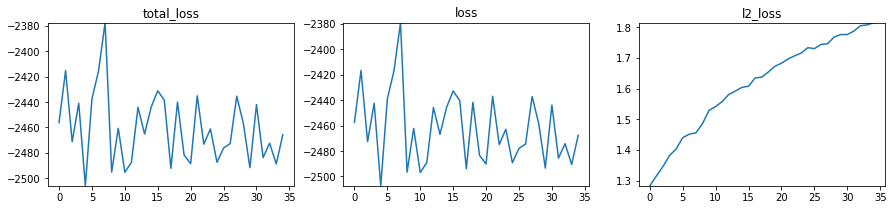

 41%|████      | 4102/10000 [07:05<10:12,  9.63it/s]

total_loss -2455.165
loss -2456.9883
l2_loss 1.8232311


 42%|████▏     | 4201/10000 [07:16<10:02,  9.63it/s]

total_loss -2464.7876
loss -2466.6155
l2_loss 1.8277661


 43%|████▎     | 4301/10000 [07:26<09:51,  9.64it/s]

total_loss -2505.0906
loss -2506.9263
l2_loss 1.8356559


 44%|████▍     | 4401/10000 [07:36<09:40,  9.64it/s]

total_loss -2481.3936
loss -2483.245
l2_loss 1.8515944


 45%|████▌     | 4501/10000 [07:46<09:30,  9.64it/s]

total_loss -2481.3303
loss -2483.1992
l2_loss 1.8687948


 46%|████▌     | 4602/10000 [07:57<09:19,  9.65it/s]

total_loss -2505.4436
loss -2507.3071
l2_loss 1.8635693


 47%|████▋     | 4702/10000 [08:07<09:08,  9.65it/s]

total_loss -2479.7456
loss -2481.6143
l2_loss 1.8687483


 48%|████▊     | 4801/10000 [08:17<08:58,  9.65it/s]

total_loss -2459.6658
loss -2461.5464
l2_loss 1.8806779


 49%|████▉     | 4901/10000 [08:27<08:48,  9.66it/s]

total_loss -2458.038
loss -2459.9246
l2_loss 1.8865757


 50%|████▉     | 4998/10000 [08:37<08:37,  9.66it/s]

total_loss -2447.0815
loss -2448.9702
l2_loss 1.888658


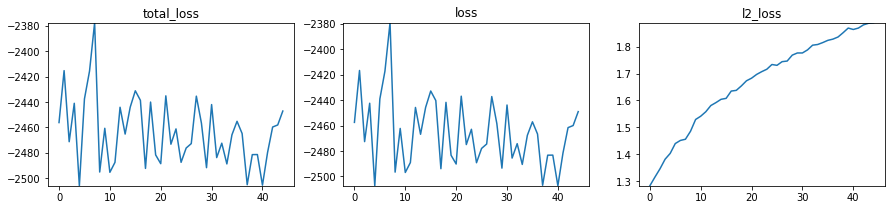

 51%|█████     | 5101/10000 [08:48<08:27,  9.65it/s]

total_loss -2497.7527
loss -2499.6516
l2_loss 1.8988954


 52%|█████▏    | 5200/10000 [08:58<08:16,  9.66it/s]

total_loss -2500.5237
loss -2502.4287
l2_loss 1.9049293


 53%|█████▎    | 5302/10000 [09:08<08:06,  9.66it/s]

total_loss -2458.2598
loss -2460.1729
l2_loss 1.9130499


 54%|█████▍    | 5401/10000 [09:18<07:55,  9.67it/s]

total_loss -2442.6978
loss -2444.6157
l2_loss 1.9178953


 55%|█████▌    | 5500/10000 [09:28<07:44,  9.68it/s]

total_loss -2487.5737
loss -2489.5002
l2_loss 1.9264184


 56%|█████▌    | 5602/10000 [09:36<07:32,  9.71it/s]

total_loss -2497.9968
loss -2499.9414
l2_loss 1.9446689


 57%|█████▋    | 5702/10000 [09:45<07:21,  9.74it/s]

total_loss -2502.832
loss -2504.7725
l2_loss 1.9403598


 58%|█████▊    | 5802/10000 [09:54<07:10,  9.76it/s]

total_loss -2469.7722
loss -2471.7178
l2_loss 1.9455836


 59%|█████▉    | 5902/10000 [10:03<06:58,  9.78it/s]

total_loss -2498.469
loss -2500.4258
l2_loss 1.956827


 60%|█████▉    | 5998/10000 [10:11<06:48,  9.81it/s]

total_loss -2427.0183
loss -2428.977
l2_loss 1.9588299


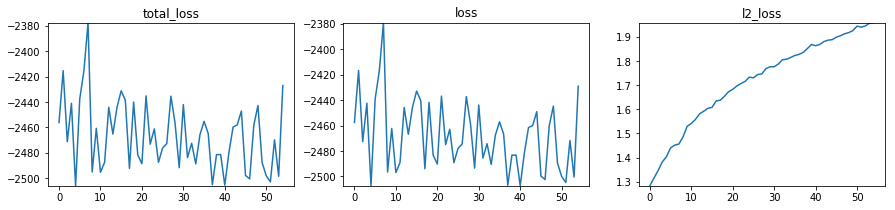

 61%|██████    | 6102/10000 [10:21<06:36,  9.82it/s]

total_loss -2502.544
loss -2504.5125
l2_loss 1.9684961


 62%|██████▏   | 6202/10000 [10:29<06:25,  9.85it/s]

total_loss -2501.6729
loss -2503.6462
l2_loss 1.9734701


 63%|██████▎   | 6302/10000 [10:38<06:14,  9.87it/s]

total_loss -2527.075
loss -2529.0552
l2_loss 1.9801047


 64%|██████▍   | 6402/10000 [10:47<06:03,  9.89it/s]

total_loss -2445.5676
loss -2447.5635
l2_loss 1.9958111


 65%|██████▌   | 6502/10000 [10:55<05:52,  9.91it/s]

total_loss -2484.9634
loss -2486.967
l2_loss 2.003609


 66%|██████▌   | 6602/10000 [11:04<05:42,  9.93it/s]

total_loss -2491.153
loss -2493.1567
l2_loss 2.0036485


 67%|██████▋   | 6702/10000 [11:13<05:31,  9.95it/s]

total_loss -2419.0193
loss -2421.0386
l2_loss 2.0192423


 68%|██████▊   | 6802/10000 [11:22<05:20,  9.97it/s]

total_loss -2485.2112
loss -2487.2285
l2_loss 2.017297


 69%|██████▉   | 6902/10000 [11:31<05:10,  9.99it/s]

total_loss -2500.9429
loss -2502.953
l2_loss 2.0099084


 70%|██████▉   | 6998/10000 [11:39<05:00, 10.01it/s]

total_loss -2557.5923
loss -2559.602
l2_loss 2.0096958


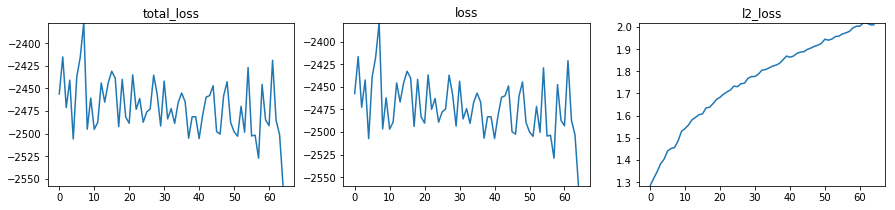

 71%|███████   | 7102/10000 [11:49<04:49, 10.01it/s]

total_loss -2513.6548
loss -2515.6758
l2_loss 2.0209625


 72%|███████▏  | 7202/10000 [11:59<04:39, 10.01it/s]

total_loss -2532.5793
loss -2534.6074
l2_loss 2.0279849


 73%|███████▎  | 7302/10000 [12:09<04:29, 10.00it/s]

total_loss -2525.3955
loss -2527.4277
l2_loss 2.0321229


 74%|███████▍  | 7402/10000 [12:20<04:19, 10.00it/s]

total_loss -2450.2678
loss -2452.3013
l2_loss 2.0333376


 75%|███████▌  | 7501/10000 [12:29<04:09, 10.01it/s]

total_loss -2479.167
loss -2481.2107
l2_loss 2.0435805


 76%|███████▌  | 7601/10000 [12:37<03:59, 10.03it/s]

total_loss -2393.4338
loss -2395.4844
l2_loss 2.05044


 77%|███████▋  | 7701/10000 [12:46<03:48, 10.05it/s]

total_loss -2464.2244
loss -2466.2808
l2_loss 2.0563934


 78%|███████▊  | 7802/10000 [12:55<03:38, 10.06it/s]

total_loss -2503.1062
loss -2505.1562
l2_loss 2.0499983


 79%|███████▉  | 7901/10000 [13:05<03:28, 10.06it/s]

total_loss -2476.5315
loss -2478.5808
l2_loss 2.0492256


 80%|███████▉  | 7999/10000 [13:14<03:18, 10.07it/s]

total_loss -2499.9053
loss -2501.97
l2_loss 2.0645778


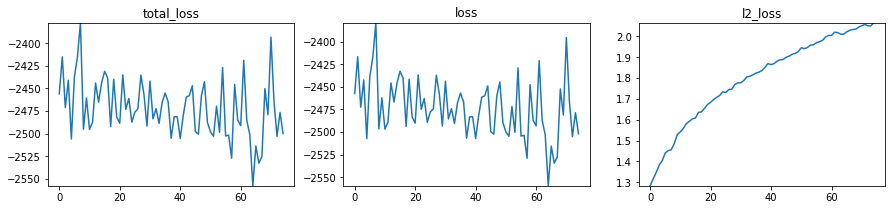

 81%|████████  | 8101/10000 [13:23<03:08, 10.08it/s]

total_loss -2470.4136
loss -2472.473
l2_loss 2.0593815


 82%|████████▏ | 8201/10000 [13:32<02:58, 10.10it/s]

total_loss -2504.2373
loss -2506.3115
l2_loss 2.0741625


 83%|████████▎ | 8301/10000 [13:41<02:48, 10.11it/s]

total_loss -2489.3079
loss -2491.393
l2_loss 2.085318


 84%|████████▍ | 8401/10000 [13:49<02:37, 10.12it/s]

total_loss -2478.461
loss -2480.5344
l2_loss 2.0735598


 85%|████████▌ | 8501/10000 [13:58<02:27, 10.14it/s]

total_loss -2504.731
loss -2506.8147
l2_loss 2.0836816


 86%|████████▌ | 8601/10000 [14:07<02:17, 10.15it/s]

total_loss -2425.3245
loss -2427.4077
l2_loss 2.0831976


 87%|████████▋ | 8701/10000 [14:16<02:07, 10.16it/s]

total_loss -2478.6335
loss -2480.7166
l2_loss 2.083039


 88%|████████▊ | 8801/10000 [14:25<01:57, 10.17it/s]

total_loss -2564.1465
loss -2566.2437
l2_loss 2.0971112


 89%|████████▉ | 8901/10000 [14:33<01:47, 10.19it/s]

total_loss -2467.4573
loss -2469.5422
l2_loss 2.0849123


 90%|████████▉ | 8999/10000 [14:42<01:38, 10.20it/s]

total_loss -2466.7195
loss -2468.8247
l2_loss 2.1051555


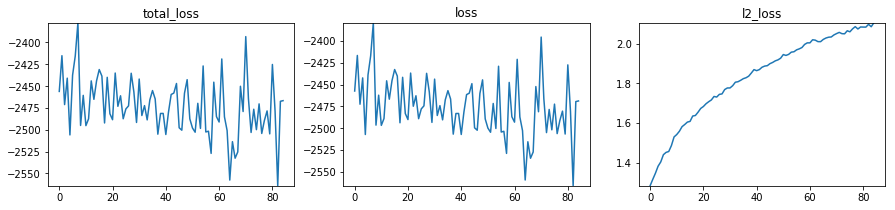

 91%|█████████ | 9101/10000 [14:51<01:28, 10.21it/s]

total_loss -2484.2297
loss -2486.3457
l2_loss 2.1158826


 92%|█████████▏| 9202/10000 [15:00<01:18, 10.21it/s]

total_loss -2480.2073
loss -2482.322
l2_loss 2.1148221


 93%|█████████▎| 9302/10000 [15:10<01:08, 10.22it/s]

total_loss -2449.1216
loss -2451.2524
l2_loss 2.1309078


 94%|█████████▍| 9401/10000 [15:20<00:58, 10.22it/s]

total_loss -2503.208
loss -2505.3374
l2_loss 2.1293592


 95%|█████████▌| 9501/10000 [15:30<00:48, 10.21it/s]

total_loss -2527.0762
loss -2529.206
l2_loss 2.129802


 96%|█████████▌| 9601/10000 [15:40<00:39, 10.21it/s]

total_loss -2482.063
loss -2484.1934
l2_loss 2.1303892


 97%|█████████▋| 9701/10000 [15:50<00:29, 10.20it/s]

total_loss -2494.3176
loss -2496.4568
l2_loss 2.1390483


 98%|█████████▊| 9801/10000 [16:00<00:19, 10.20it/s]

total_loss -2480.516
loss -2482.6582
l2_loss 2.142129


 99%|█████████▉| 9901/10000 [16:11<00:09, 10.20it/s]

total_loss -2457.6929
loss -2459.8384
l2_loss 2.145406


100%|█████████▉| 9999/10000 [16:21<00:00, 10.19it/s]

total_loss -2505.343
loss -2507.478
l2_loss 2.1349878


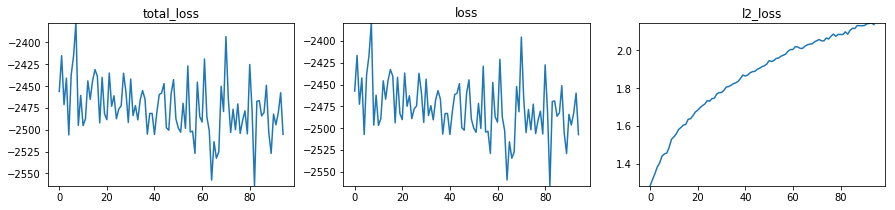

100%|██████████| 10000/10000 [16:21<00:00, 10.19it/s]


In [30]:
utils.trainer(
    sess, 
    num_steps=10000, 
    train_op=train_op, 
    feed_dict_fn=lambda: {lr_ph: 0.005, beta_ph: 1.0}, 
    metrics=[metrics], 
    hooks=[plot_metrics_hook]
)

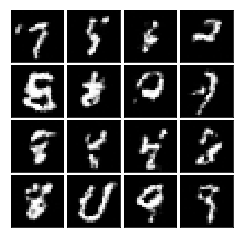

In [31]:
x_samples_np = x_flow_sampled.eval(feed_dict={lr_ph: 0.0, beta_ph: 1.0})
utils.plot_4x4_grid(x_samples_np, shape=x_samples_np.shape[1:3])

### Train model with lr=0.001

  1%|          | 102/10000 [00:10<16:49,  9.80it/s]

total_loss -2527.1619
loss -2529.2793
l2_loss 2.1173363


  2%|▏         | 201/10000 [00:20<16:44,  9.75it/s]

total_loss -2529.8257
loss -2531.9248
l2_loss 2.0991478


  3%|▎         | 302/10000 [00:30<16:34,  9.75it/s]

total_loss -2473.7063
loss -2475.7886
l2_loss 2.0822246


  4%|▍         | 401/10000 [00:41<16:26,  9.73it/s]

total_loss -2517.8125
loss -2519.8784
l2_loss 2.066006


  5%|▌         | 501/10000 [00:51<16:16,  9.72it/s]

total_loss -2515.7554
loss -2517.8066
l2_loss 2.051333


  6%|▌         | 601/10000 [01:00<15:49,  9.90it/s]

total_loss -2483.8853
loss -2485.9229
l2_loss 2.037537


  7%|▋         | 701/10000 [01:09<15:20, 10.10it/s]

total_loss -2504.8901
loss -2506.9146
l2_loss 2.0243914


  8%|▊         | 801/10000 [01:19<15:12, 10.08it/s]

total_loss -2491.8203
loss -2493.8328
l2_loss 2.012379


  9%|▉         | 900/10000 [01:29<15:07, 10.03it/s]

total_loss -2499.7847
loss -2501.7847
l2_loss 1.9999149


 10%|▉         | 999/10000 [01:39<14:58, 10.02it/s]

total_loss -2493.659
loss -2495.6475
l2_loss 1.9884197


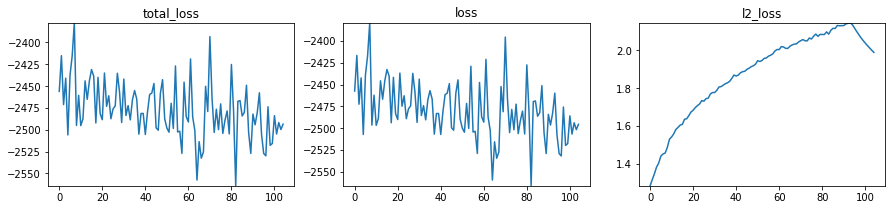

 11%|█         | 1101/10000 [01:50<14:51,  9.98it/s]

total_loss -2501.478
loss -2503.4565
l2_loss 1.9784819


 12%|█▏        | 1201/10000 [02:00<14:43,  9.96it/s]

total_loss -2477.9187
loss -2479.8877
l2_loss 1.9689536


 13%|█▎        | 1301/10000 [02:10<14:33,  9.96it/s]

total_loss -2562.9805
loss -2564.9404
l2_loss 1.9598508


 14%|█▍        | 1401/10000 [02:20<14:20,  9.99it/s]

total_loss -2508.358
loss -2510.3076
l2_loss 1.9496288


 15%|█▌        | 1501/10000 [02:29<14:04, 10.07it/s]

total_loss -2540.8718
loss -2542.8137
l2_loss 1.9419789


 16%|█▌        | 1601/10000 [02:38<13:53, 10.08it/s]

total_loss -2534.4456
loss -2536.3804
l2_loss 1.934925


 17%|█▋        | 1701/10000 [02:49<13:44, 10.06it/s]

total_loss -2522.934
loss -2524.8613
l2_loss 1.9273381


 18%|█▊        | 1801/10000 [02:59<13:36, 10.04it/s]

total_loss -2524.408
loss -2526.3276
l2_loss 1.9197135


 19%|█▉        | 1902/10000 [03:09<13:26, 10.04it/s]

total_loss -2489.7913
loss -2491.705
l2_loss 1.9137621


 20%|█▉        | 1999/10000 [03:19<13:18, 10.02it/s]

total_loss -2456.8833
loss -2458.79
l2_loss 1.9067098


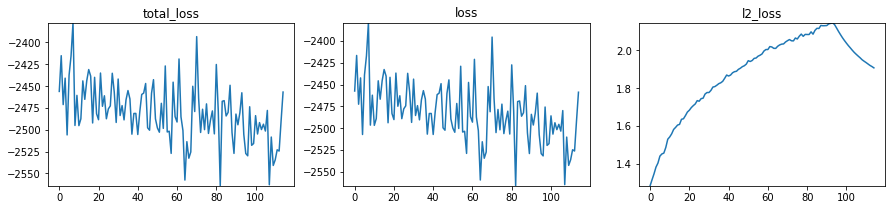

 21%|██        | 2101/10000 [03:30<13:10,  9.99it/s]

total_loss -2491.3777
loss -2493.2783
l2_loss 1.9005798


 22%|██▏       | 2202/10000 [03:40<13:00, 10.00it/s]

total_loss -2495.2039
loss -2497.0986
l2_loss 1.8948901


 23%|██▎       | 2302/10000 [03:50<12:50,  9.99it/s]

total_loss -2546.125
loss -2548.015
l2_loss 1.8899906


 24%|██▍       | 2402/10000 [04:00<12:40,  9.99it/s]

total_loss -2511.7288
loss -2513.6138
l2_loss 1.884893


 25%|██▌       | 2501/10000 [04:10<12:31,  9.98it/s]

total_loss -2501.9155
loss -2503.7954
l2_loss 1.8797855


 26%|██▌       | 2601/10000 [04:20<12:22,  9.97it/s]

total_loss -2540.1401
loss -2542.0156
l2_loss 1.8755802


 27%|██▋       | 2702/10000 [04:30<12:11,  9.97it/s]

total_loss -2502.178
loss -2504.0483
l2_loss 1.8704301


 28%|██▊       | 2802/10000 [04:41<12:02,  9.97it/s]

total_loss -2512.4348
loss -2514.3008
l2_loss 1.8659632


 29%|██▉       | 2902/10000 [04:51<11:52,  9.96it/s]

total_loss -2496.8745
loss -2498.7368
l2_loss 1.8623532


 30%|██▉       | 2999/10000 [05:01<11:43,  9.95it/s]

total_loss -2502.256
loss -2504.1143
l2_loss 1.8582324


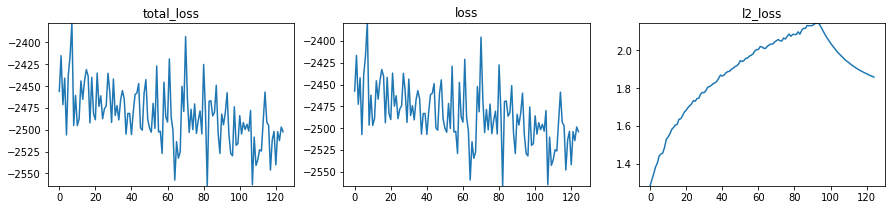

 31%|███       | 3102/10000 [05:12<11:34,  9.94it/s]

total_loss -2519.769
loss -2521.624
l2_loss 1.8548672


 32%|███▏      | 3202/10000 [05:22<11:24,  9.94it/s]

total_loss -2493.838
loss -2495.6902
l2_loss 1.852266


 33%|███▎      | 3301/10000 [05:32<11:14,  9.93it/s]

total_loss -2537.3552
loss -2539.204
l2_loss 1.8488449


 34%|███▍      | 3401/10000 [05:42<11:04,  9.93it/s]

total_loss -2478.6973
loss -2480.5437
l2_loss 1.8464172


 35%|███▌      | 3500/10000 [05:52<10:54,  9.93it/s]

total_loss -2503.4763
loss -2505.3213
l2_loss 1.8448588


 36%|███▌      | 3601/10000 [06:03<10:45,  9.92it/s]

total_loss -2507.2566
loss -2509.0986
l2_loss 1.841991


 37%|███▋      | 3701/10000 [06:13<10:35,  9.92it/s]

total_loss -2542.6025
loss -2544.4434
l2_loss 1.8408493


 38%|███▊      | 3801/10000 [06:23<10:25,  9.91it/s]

total_loss -2521.1094
loss -2522.9475
l2_loss 1.8382318


 39%|███▉      | 3901/10000 [06:33<10:15,  9.91it/s]

total_loss -2493.073
loss -2494.9082
l2_loss 1.835294


 40%|███▉      | 3999/10000 [06:43<10:04,  9.92it/s]

total_loss -2519.4297
loss -2521.262
l2_loss 1.8323239


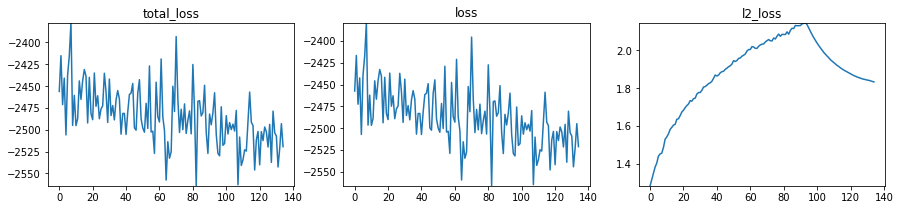

 41%|████      | 4101/10000 [06:53<09:55,  9.91it/s]

total_loss -2531.6438
loss -2533.474
l2_loss 1.8303246


 42%|████▏     | 4201/10000 [07:03<09:45,  9.91it/s]

total_loss -2492.7214
loss -2494.5493
l2_loss 1.8277705


 43%|████▎     | 4300/10000 [07:14<09:35,  9.90it/s]

total_loss -2528.2468
loss -2530.0737
l2_loss 1.8269007


 44%|████▍     | 4401/10000 [07:24<09:25,  9.90it/s]

total_loss -2494.22
loss -2496.044
l2_loss 1.8240668


 45%|████▌     | 4502/10000 [07:34<09:15,  9.90it/s]

total_loss -2487.9172
loss -2489.7395
l2_loss 1.8222766


 46%|████▌     | 4601/10000 [07:44<09:05,  9.90it/s]

total_loss -2531.2124
loss -2533.033
l2_loss 1.8206075


 47%|████▋     | 4701/10000 [07:55<08:55,  9.89it/s]

total_loss -2527.5808
loss -2529.4004
l2_loss 1.8196555


 48%|████▊     | 4801/10000 [08:05<08:45,  9.90it/s]

total_loss -2553.351
loss -2555.1704
l2_loss 1.8193029


 49%|████▉     | 4902/10000 [08:15<08:35,  9.89it/s]

total_loss -2516.7068
loss -2518.5242
l2_loss 1.8172969


 50%|████▉     | 4998/10000 [08:25<08:25,  9.89it/s]

total_loss -2493.7468
loss -2495.5615
l2_loss 1.8145968


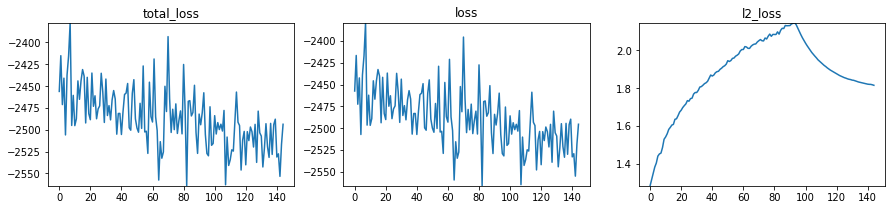

 51%|█████     | 5102/10000 [08:36<08:15,  9.89it/s]

total_loss -2490.8987
loss -2492.7126
l2_loss 1.8138961


 52%|█████▏    | 5202/10000 [08:46<08:05,  9.88it/s]

total_loss -2554.6353
loss -2556.4475
l2_loss 1.8121469


 53%|█████▎    | 5301/10000 [08:56<07:55,  9.88it/s]

total_loss -2516.3687
loss -2518.1797
l2_loss 1.8109397


 54%|█████▍    | 5401/10000 [09:06<07:45,  9.88it/s]

total_loss -2530.7373
loss -2532.547
l2_loss 1.8098316


 55%|█████▌    | 5501/10000 [09:16<07:35,  9.88it/s]

total_loss -2516.4268
loss -2518.2356
l2_loss 1.8088712


 56%|█████▌    | 5601/10000 [09:26<07:25,  9.88it/s]

total_loss -2480.0715
loss -2481.8787
l2_loss 1.8072379


 57%|█████▋    | 5701/10000 [09:36<07:15,  9.88it/s]

total_loss -2491.8755
loss -2493.6826
l2_loss 1.8072009


 58%|█████▊    | 5800/10000 [09:47<07:05,  9.88it/s]

total_loss -2528.4653
loss -2530.271
l2_loss 1.805623


 59%|█████▉    | 5902/10000 [09:57<06:54,  9.88it/s]

total_loss -2477.8323
loss -2479.6377
l2_loss 1.8054501


 60%|█████▉    | 5998/10000 [10:07<06:45,  9.87it/s]

total_loss -2472.648
loss -2474.4517
l2_loss 1.8037624


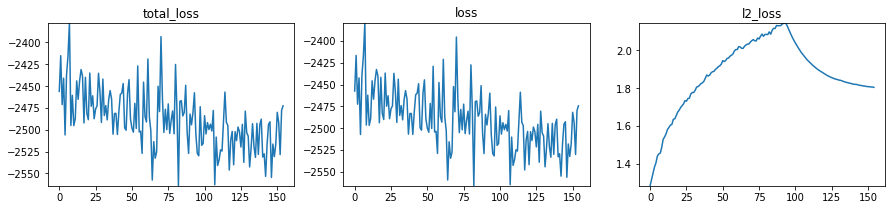

 61%|██████    | 6101/10000 [10:18<06:35,  9.87it/s]

total_loss -2511.7058
loss -2513.5098
l2_loss 1.8038833


 62%|██████▏   | 6201/10000 [10:28<06:25,  9.87it/s]

total_loss -2457.7085
loss -2459.512
l2_loss 1.8034608


 63%|██████▎   | 6302/10000 [10:38<06:14,  9.87it/s]

total_loss -2526.349
loss -2528.152
l2_loss 1.8030022


 64%|██████▍   | 6401/10000 [10:48<06:04,  9.87it/s]

total_loss -2529.0293
loss -2530.8315
l2_loss 1.8022918


 65%|██████▌   | 6501/10000 [10:59<05:54,  9.86it/s]

total_loss -2481.3833
loss -2483.1846
l2_loss 1.8012501


 66%|██████▌   | 6601/10000 [11:09<05:44,  9.86it/s]

total_loss -2505.4656
loss -2507.2666
l2_loss 1.8009348


 67%|██████▋   | 6701/10000 [11:19<05:34,  9.86it/s]

total_loss -2539.5447
loss -2541.3447
l2_loss 1.8000815


 68%|██████▊   | 6801/10000 [11:29<05:24,  9.86it/s]

total_loss -2487.8052
loss -2489.604
l2_loss 1.7988317


 69%|██████▉   | 6900/10000 [11:39<05:14,  9.86it/s]

total_loss -2541.1028
loss -2542.9014
l2_loss 1.7985258


 70%|██████▉   | 6999/10000 [11:49<05:04,  9.86it/s]

total_loss -2524.8228
loss -2526.621
l2_loss 1.798257


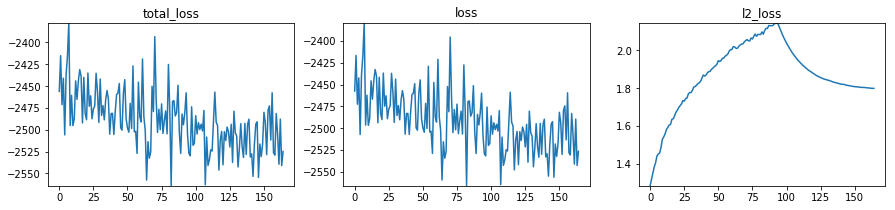

 71%|███████   | 7101/10000 [12:00<04:54,  9.85it/s]

total_loss -2532.1533
loss -2533.9512
l2_loss 1.7978779


 72%|███████▏  | 7200/10000 [12:10<04:44,  9.85it/s]

total_loss -2477.9854
loss -2479.7825
l2_loss 1.7970046


 73%|███████▎  | 7302/10000 [12:21<04:33,  9.85it/s]

total_loss -2527.861
loss -2529.6582
l2_loss 1.7970403


 74%|███████▍  | 7402/10000 [12:31<04:23,  9.85it/s]

total_loss -2448.597
loss -2450.3936
l2_loss 1.7965724


 75%|███████▌  | 7501/10000 [12:41<04:13,  9.85it/s]

total_loss -2537.8557
loss -2539.6514
l2_loss 1.7957385


 76%|███████▌  | 7601/10000 [12:51<04:03,  9.85it/s]

total_loss -2499.1663
loss -2500.9607
l2_loss 1.7944436


 77%|███████▋  | 7701/10000 [13:02<03:53,  9.85it/s]

total_loss -2467.9727
loss -2469.7659
l2_loss 1.7933118


 78%|███████▊  | 7802/10000 [13:12<03:43,  9.85it/s]

total_loss -2498.536
loss -2500.3296
l2_loss 1.7936276


 79%|███████▉  | 7901/10000 [13:22<03:33,  9.85it/s]

total_loss -2472.8225
loss -2474.6155
l2_loss 1.792899


 80%|███████▉  | 7999/10000 [13:32<03:23,  9.85it/s]

total_loss -2496.961
loss -2498.7546
l2_loss 1.7936468


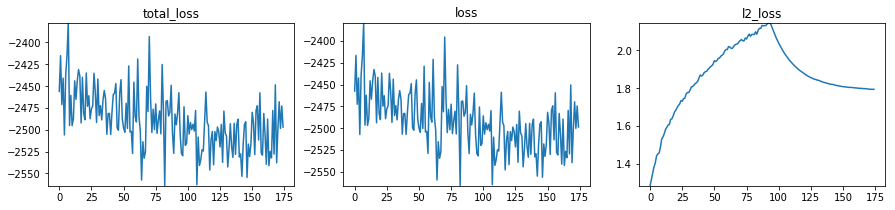

 81%|████████  | 8100/10000 [13:43<03:13,  9.84it/s]

total_loss -2491.7732
loss -2493.5667
l2_loss 1.7935457


 82%|████████▏ | 8201/10000 [13:53<03:02,  9.84it/s]

total_loss -2484.928
loss -2486.7207
l2_loss 1.7927213


 83%|████████▎ | 8301/10000 [14:03<02:52,  9.84it/s]

total_loss -2505.8604
loss -2507.6528
l2_loss 1.7924045


 84%|████████▍ | 8402/10000 [14:14<02:42,  9.84it/s]

total_loss -2534.054
loss -2535.847
l2_loss 1.7930807


 85%|████████▌ | 8501/10000 [14:24<02:32,  9.84it/s]

total_loss -2546.6855
loss -2548.4788
l2_loss 1.7931991


 86%|████████▌ | 8601/10000 [14:34<02:22,  9.83it/s]

total_loss -2504.1318
loss -2505.924
l2_loss 1.7921935


 87%|████████▋ | 8702/10000 [14:45<02:12,  9.83it/s]

total_loss -2488.133
loss -2489.9238
l2_loss 1.790883


 88%|████████▊ | 8801/10000 [14:55<02:01,  9.83it/s]

total_loss -2528.3184
loss -2530.1086
l2_loss 1.7902842


 89%|████████▉ | 8901/10000 [15:05<01:51,  9.83it/s]

total_loss -2533.2107
loss -2535.0
l2_loss 1.7893735


 90%|████████▉ | 8999/10000 [15:15<01:41,  9.83it/s]

total_loss -2576.5474
loss -2578.3362
l2_loss 1.7888644


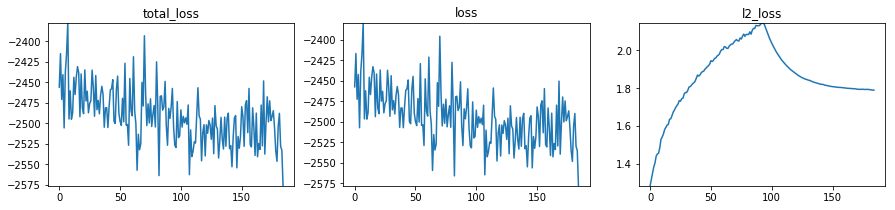

 91%|█████████ | 9101/10000 [15:26<01:31,  9.82it/s]

total_loss -2533.3115
loss -2535.101
l2_loss 1.7896633


 92%|█████████▏| 9201/10000 [15:36<01:21,  9.83it/s]

total_loss -2472.36
loss -2474.151
l2_loss 1.7907764


 93%|█████████▎| 9301/10000 [15:45<01:11,  9.83it/s]

total_loss -2526.7212
loss -2528.5112
l2_loss 1.789941


 94%|█████████▍| 9401/10000 [15:55<01:00,  9.84it/s]

total_loss -2528.6702
loss -2530.4592
l2_loss 1.789087


 95%|█████████▌| 9501/10000 [16:05<00:50,  9.84it/s]

total_loss -2520.1516
loss -2521.941
l2_loss 1.7892448


 96%|█████████▌| 9602/10000 [16:15<00:40,  9.85it/s]

total_loss -2505.9824
loss -2507.7705
l2_loss 1.788131


 97%|█████████▋| 9700/10000 [16:25<00:30,  9.85it/s]

total_loss -2504.479
loss -2506.2666
l2_loss 1.7876042


 98%|█████████▊| 9801/10000 [16:35<00:20,  9.85it/s]

total_loss -2464.1738
loss -2465.9602
l2_loss 1.786425


 99%|█████████▉| 9902/10000 [16:45<00:09,  9.85it/s]

total_loss -2510.9563
loss -2512.747
l2_loss 1.790666


100%|█████████▉| 9999/10000 [16:55<00:00,  9.85it/s]

total_loss -2495.082
loss -2496.873
l2_loss 1.7909878


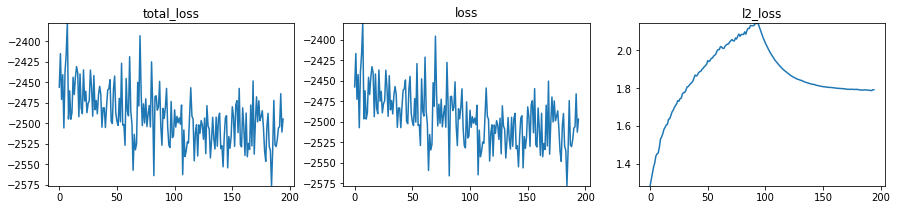

100%|██████████| 10000/10000 [16:55<00:00,  9.85it/s]


In [32]:
utils.trainer(
    sess, 
    num_steps=10000, 
    train_op=train_op, 
    feed_dict_fn=lambda: {lr_ph: 0.001, beta_ph: 1.}, 
    metrics=[metrics], 
    hooks=[plot_metrics_hook]
)

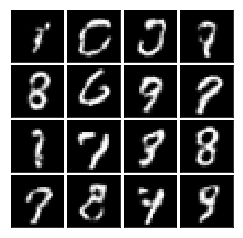

In [33]:
x_samples_np = x_flow_sampled.eval(feed_dict={lr_ph: 0.0, beta_ph: 0.6})
utils.plot_4x4_grid(x_samples_np, shape=x_samples_np.shape[1:3])

### Train model with lr=0.0001

  1%|          | 101/10000 [00:10<16:53,  9.77it/s]

total_loss -2520.7332
loss -2522.5234
l2_loss 1.7903744


  2%|▏         | 200/10000 [00:20<16:37,  9.82it/s]

total_loss -2534.9712
loss -2536.761
l2_loss 1.78971


  3%|▎         | 301/10000 [00:30<16:31,  9.78it/s]

total_loss -2490.434
loss -2492.2231
l2_loss 1.7890627


  4%|▍         | 401/10000 [00:40<16:18,  9.81it/s]

total_loss -2511.8796
loss -2513.668
l2_loss 1.7883976


  5%|▌         | 501/10000 [00:51<16:10,  9.79it/s]

total_loss -2533.4524
loss -2535.2402
l2_loss 1.7878163


  6%|▌         | 602/10000 [01:01<15:57,  9.82it/s]

total_loss -2467.8555
loss -2469.6426
l2_loss 1.7872297


  7%|▋         | 700/10000 [01:11<15:47,  9.81it/s]

total_loss -2524.2283
loss -2526.015
l2_loss 1.7865628


  8%|▊         | 802/10000 [01:21<15:36,  9.82it/s]

total_loss -2551.4036
loss -2553.1895
l2_loss 1.7858847


  9%|▉         | 902/10000 [01:31<15:26,  9.82it/s]

total_loss -2553.8142
loss -2555.5996
l2_loss 1.7853069


 10%|▉         | 999/10000 [01:41<15:16,  9.82it/s]

total_loss -2477.211
loss -2478.9956
l2_loss 1.7847306


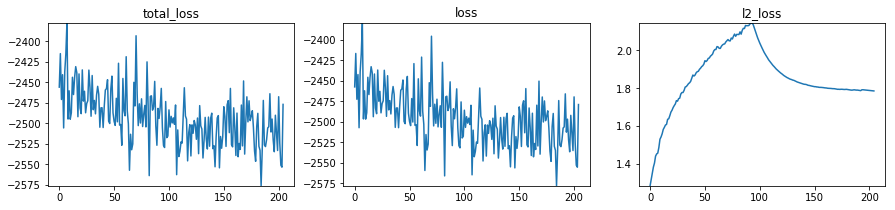

 11%|█         | 1101/10000 [01:52<15:09,  9.78it/s]

total_loss -2492.939
loss -2494.7231
l2_loss 1.7841324


 12%|█▏        | 1202/10000 [02:02<14:59,  9.78it/s]

total_loss -2501.7517
loss -2503.5352
l2_loss 1.7834446


 13%|█▎        | 1302/10000 [02:12<14:44,  9.83it/s]

total_loss -2560.651
loss -2562.4336
l2_loss 1.7828354


 14%|█▍        | 1402/10000 [02:21<14:26,  9.93it/s]

total_loss -2497.738
loss -2499.5203
l2_loss 1.7823167


 15%|█▌        | 1500/10000 [02:29<14:09, 10.00it/s]

total_loss -2558.239
loss -2560.0208
l2_loss 1.7817897


 16%|█▌        | 1602/10000 [02:38<13:53, 10.08it/s]

total_loss -2495.6035
loss -2497.3848
l2_loss 1.7813427


 17%|█▋        | 1702/10000 [02:47<13:37, 10.15it/s]

total_loss -2495.9155
loss -2497.6965
l2_loss 1.7809248


 18%|█▊        | 1802/10000 [02:56<13:22, 10.21it/s]

total_loss -2539.9177
loss -2541.6982
l2_loss 1.7805754


 19%|█▉        | 1902/10000 [03:05<13:08, 10.27it/s]

total_loss -2502.6626
loss -2504.4426
l2_loss 1.7800752


 20%|█▉        | 1998/10000 [03:14<12:59, 10.26it/s]

total_loss -2548.6
loss -2550.3794
l2_loss 1.7794122


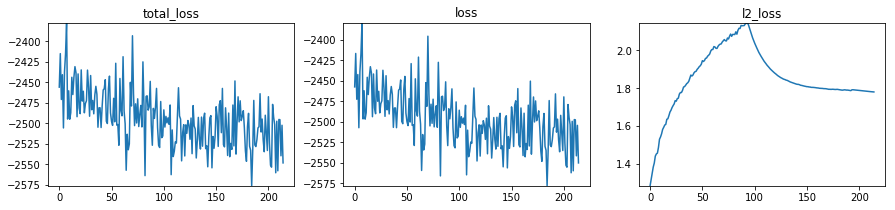

 21%|██        | 2102/10000 [03:25<12:53, 10.22it/s]

total_loss -2550.7512
loss -2552.53
l2_loss 1.7788728


 22%|██▏       | 2202/10000 [03:36<12:45, 10.19it/s]

total_loss -2546.5938
loss -2548.372
l2_loss 1.7783012


 23%|██▎       | 2302/10000 [03:46<12:36, 10.18it/s]

total_loss -2535.2336
loss -2537.0115
l2_loss 1.7778298


 24%|██▍       | 2401/10000 [03:56<12:27, 10.17it/s]

total_loss -2516.117
loss -2517.8943
l2_loss 1.777419


 25%|██▌       | 2501/10000 [04:06<12:18, 10.15it/s]

total_loss -2497.573
loss -2499.3499
l2_loss 1.7768394


 26%|██▌       | 2601/10000 [04:16<12:10, 10.13it/s]

total_loss -2518.2505
loss -2520.0269
l2_loss 1.7763416


 27%|██▋       | 2701/10000 [04:26<12:01, 10.12it/s]

total_loss -2541.0051
loss -2542.7808
l2_loss 1.7757562


 28%|██▊       | 2802/10000 [04:37<11:52, 10.11it/s]

total_loss -2510.926
loss -2512.7014
l2_loss 1.7754219


 29%|██▉       | 2901/10000 [04:47<11:43, 10.09it/s]

total_loss -2486.824
loss -2488.599
l2_loss 1.7750969


 30%|██▉       | 2999/10000 [04:57<11:34, 10.08it/s]

total_loss -2461.4602
loss -2463.2349
l2_loss 1.7746639


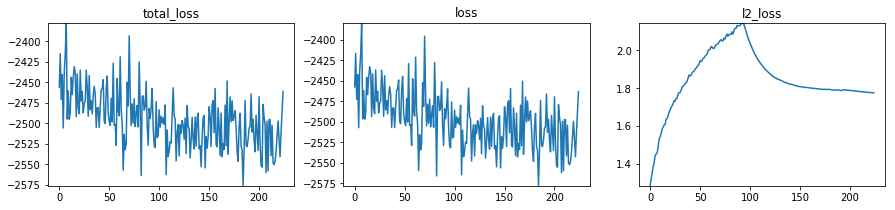

 31%|███       | 3101/10000 [05:07<11:23, 10.10it/s]

total_loss -2490.0942
loss -2491.8687
l2_loss 1.7743229


 32%|███▏      | 3201/10000 [05:15<11:10, 10.14it/s]

total_loss -2418.339
loss -2420.113
l2_loss 1.773902


 33%|███▎      | 3301/10000 [05:24<10:58, 10.17it/s]

total_loss -2589.9546
loss -2591.728
l2_loss 1.7735016


 34%|███▍      | 3401/10000 [05:33<10:47, 10.20it/s]

total_loss -2538.0752
loss -2539.8481
l2_loss 1.773063


 35%|███▌      | 3501/10000 [05:42<10:35, 10.23it/s]

total_loss -2571.4973
loss -2573.27
l2_loss 1.7727123


 36%|███▌      | 3601/10000 [05:50<10:23, 10.26it/s]

total_loss -2511.0579
loss -2512.83
l2_loss 1.7723235


 37%|███▋      | 3701/10000 [05:59<10:12, 10.29it/s]

total_loss -2536.318
loss -2538.09
l2_loss 1.7720387


 38%|███▊      | 3801/10000 [06:08<10:00, 10.32it/s]

total_loss -2501.2285
loss -2503.0002
l2_loss 1.7717066


 39%|███▉      | 3901/10000 [06:17<09:50, 10.33it/s]

total_loss -2498.4023
loss -2500.1736
l2_loss 1.7711719


 40%|███▉      | 3999/10000 [06:27<09:41, 10.32it/s]

total_loss -2514.4646
loss -2516.2354
l2_loss 1.7707453


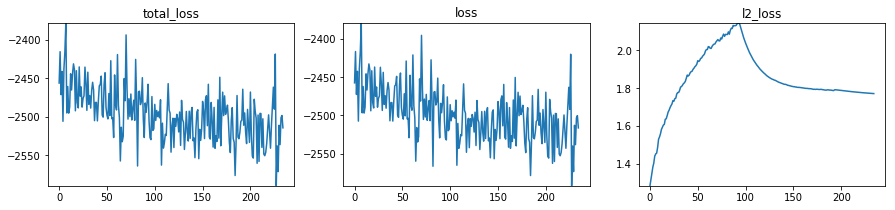

 41%|████      | 4102/10000 [06:38<09:32, 10.30it/s]

total_loss -2513.1655
loss -2514.9358
l2_loss 1.7703431


 42%|████▏     | 4200/10000 [06:48<09:23, 10.29it/s]

total_loss -2531.074
loss -2532.844
l2_loss 1.7699502


 43%|████▎     | 4301/10000 [06:58<09:14, 10.27it/s]

total_loss -2509.385
loss -2511.1548
l2_loss 1.7697129


 44%|████▍     | 4401/10000 [07:08<09:05, 10.26it/s]

total_loss -2514.243
loss -2516.0122
l2_loss 1.7694069


 45%|████▌     | 4501/10000 [07:19<08:56, 10.25it/s]

total_loss -2508.158
loss -2509.927
l2_loss 1.7689219


 46%|████▌     | 4601/10000 [07:29<08:47, 10.24it/s]

total_loss -2605.482
loss -2607.2505
l2_loss 1.7685076


 47%|████▋     | 4702/10000 [07:39<08:38, 10.23it/s]

total_loss -2530.0925
loss -2531.8608
l2_loss 1.7682179


 48%|████▊     | 4801/10000 [07:49<08:28, 10.22it/s]

total_loss -2527.4426
loss -2529.2104
l2_loss 1.7677965


 49%|████▉     | 4901/10000 [07:59<08:19, 10.21it/s]

total_loss -2485.0579
loss -2486.8252
l2_loss 1.7674053


 50%|████▉     | 4999/10000 [08:09<08:10, 10.20it/s]

total_loss -2510.492
loss -2512.259
l2_loss 1.7670628


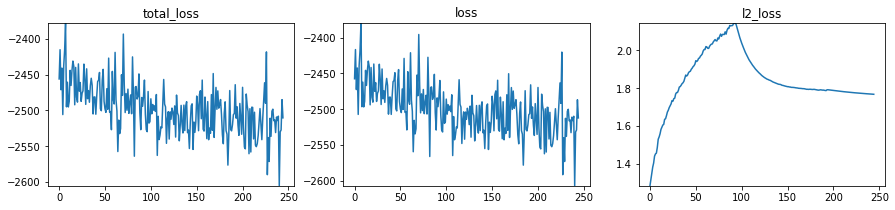

 51%|█████     | 5101/10000 [08:20<08:00, 10.19it/s]

total_loss -2496.7625
loss -2498.5293
l2_loss 1.7667366


 52%|█████▏    | 5201/10000 [08:30<07:51, 10.18it/s]

total_loss -2492.839
loss -2494.6055
l2_loss 1.7664663


 53%|█████▎    | 5301/10000 [08:40<07:41, 10.18it/s]

total_loss -2529.466
loss -2531.2322
l2_loss 1.7661285


 54%|█████▍    | 5401/10000 [08:50<07:31, 10.18it/s]

total_loss -2557.1897
loss -2558.9556
l2_loss 1.7657553


 55%|█████▌    | 5501/10000 [09:00<07:22, 10.17it/s]

total_loss -2560.284
loss -2562.0496
l2_loss 1.7655996


 56%|█████▌    | 5602/10000 [09:10<07:12, 10.17it/s]

total_loss -2516.765
loss -2518.5303
l2_loss 1.7654423


 57%|█████▋    | 5702/10000 [09:21<07:03, 10.16it/s]

total_loss -2515.4714
loss -2517.2366
l2_loss 1.7652491


 58%|█████▊    | 5802/10000 [09:31<06:53, 10.16it/s]

total_loss -2532.3286
loss -2534.0935
l2_loss 1.7648722


 59%|█████▉    | 5901/10000 [09:40<06:43, 10.16it/s]

total_loss -2500.438
loss -2502.2026
l2_loss 1.7645277


 60%|█████▉    | 5999/10000 [09:50<06:33, 10.16it/s]

total_loss -2525.3887
loss -2527.1528
l2_loss 1.7641679


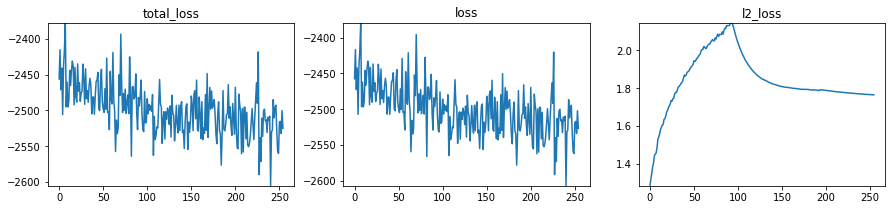

 61%|██████    | 6102/10000 [10:01<06:24, 10.15it/s]

total_loss -2510.0762
loss -2511.84
l2_loss 1.763847


 62%|██████▏   | 6202/10000 [10:11<06:14, 10.15it/s]

total_loss -2510.5815
loss -2512.3452
l2_loss 1.763667


 63%|██████▎   | 6301/10000 [10:21<06:04, 10.14it/s]

total_loss -2559.6511
loss -2561.4146
l2_loss 1.7634103


 64%|██████▍   | 6401/10000 [10:31<05:55, 10.14it/s]

total_loss -2470.9392
loss -2472.7021
l2_loss 1.7629963


 65%|██████▌   | 6500/10000 [10:41<05:45, 10.13it/s]

total_loss -2541.2998
loss -2543.0625
l2_loss 1.7626143


 66%|██████▌   | 6602/10000 [10:51<05:35, 10.13it/s]

total_loss -2543.849
loss -2545.6116
l2_loss 1.7623708


 67%|██████▋   | 6700/10000 [11:01<05:25, 10.12it/s]

total_loss -2492.3376
loss -2494.0999
l2_loss 1.76222


 68%|██████▊   | 6802/10000 [11:11<05:15, 10.12it/s]

total_loss -2559.8594
loss -2561.6213
l2_loss 1.7619276


 69%|██████▉   | 6902/10000 [11:21<05:05, 10.13it/s]

total_loss -2533.0828
loss -2534.8445
l2_loss 1.7616017


 70%|██████▉   | 6999/10000 [11:31<04:56, 10.13it/s]

total_loss -2525.131
loss -2526.8926
l2_loss 1.7614368


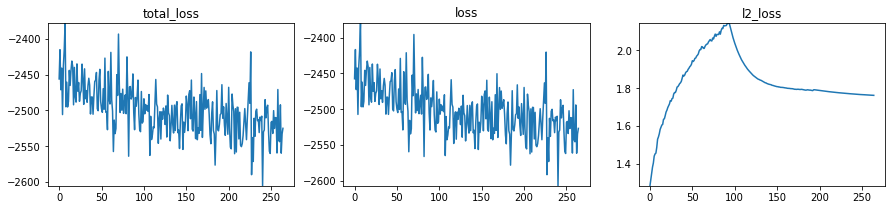

 71%|███████   | 7102/10000 [11:42<04:46, 10.11it/s]

total_loss -2503.8604
loss -2505.6213
l2_loss 1.7610232


 72%|███████▏  | 7202/10000 [11:52<04:36, 10.11it/s]

total_loss -2515.3843
loss -2517.145
l2_loss 1.7606959


 73%|███████▎  | 7302/10000 [12:02<04:26, 10.10it/s]

total_loss -2530.163
loss -2531.9233
l2_loss 1.7603488


 74%|███████▍  | 7401/10000 [12:12<04:17, 10.11it/s]

total_loss -2500.1301
loss -2501.8904
l2_loss 1.7601929


 75%|███████▌  | 7501/10000 [12:22<04:07, 10.10it/s]

total_loss -2511.5173
loss -2513.2773
l2_loss 1.7600105


 76%|███████▌  | 7601/10000 [12:32<03:57, 10.10it/s]

total_loss -2567.5796
loss -2569.3394
l2_loss 1.7598394


 77%|███████▋  | 7701/10000 [12:42<03:47, 10.10it/s]

total_loss -2523.453
loss -2525.2124
l2_loss 1.7595054


 78%|███████▊  | 7802/10000 [12:52<03:37, 10.10it/s]

total_loss -2513.6055
loss -2515.3647
l2_loss 1.759234


 79%|███████▉  | 7901/10000 [13:02<03:27, 10.09it/s]

total_loss -2549.6648
loss -2551.4238
l2_loss 1.759059


 80%|███████▉  | 7998/10000 [13:12<03:18, 10.09it/s]

total_loss -2517.2825
loss -2519.0413
l2_loss 1.7588285


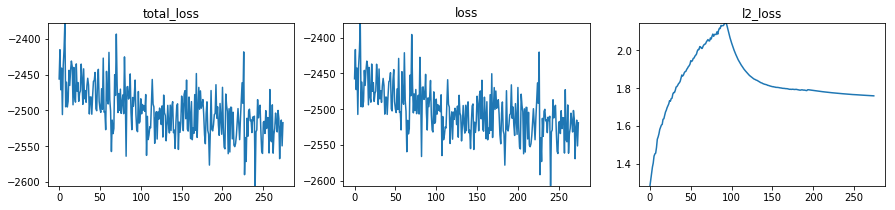

 81%|████████  | 8101/10000 [13:23<03:08, 10.08it/s]

total_loss -2494.6248
loss -2496.3833
l2_loss 1.7585763


 82%|████████▏ | 8201/10000 [13:33<02:58, 10.08it/s]

total_loss -2518.7637
loss -2520.522
l2_loss 1.7583783


 83%|████████▎ | 8301/10000 [13:43<02:48, 10.08it/s]

total_loss -2558.4158
loss -2560.1738
l2_loss 1.7581353


 84%|████████▍ | 8401/10000 [13:53<02:38, 10.08it/s]

total_loss -2569.3516
loss -2571.1094
l2_loss 1.7578254


 85%|████████▌ | 8502/10000 [14:04<02:28, 10.07it/s]

total_loss -2491.0813
loss -2492.8389
l2_loss 1.7576175


 86%|████████▌ | 8601/10000 [14:14<02:18, 10.07it/s]

total_loss -2538.769
loss -2540.5264
l2_loss 1.7573389


 87%|████████▋ | 8701/10000 [14:24<02:09, 10.06it/s]

total_loss -2525.5735
loss -2527.3306
l2_loss 1.757079


 88%|████████▊ | 8801/10000 [14:34<01:59, 10.06it/s]

total_loss -2555.7915
loss -2557.5483
l2_loss 1.7567767


 89%|████████▉ | 8901/10000 [14:44<01:49, 10.06it/s]

total_loss -2549.3271
loss -2551.0837
l2_loss 1.7566262


 90%|████████▉ | 8998/10000 [14:54<01:39, 10.05it/s]

total_loss -2542.7585
loss -2544.515
l2_loss 1.756319


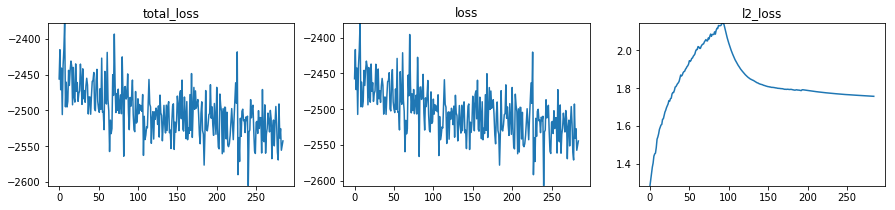

 91%|█████████ | 9102/10000 [15:04<01:29, 10.06it/s]

total_loss -2525.8552
loss -2527.6113
l2_loss 1.7561268


 92%|█████████▏| 9202/10000 [15:13<01:19, 10.07it/s]

total_loss -2527.939
loss -2529.6948
l2_loss 1.755914


 93%|█████████▎| 9302/10000 [15:22<01:09, 10.09it/s]

total_loss -2538.6733
loss -2540.4292
l2_loss 1.7558421


 94%|█████████▍| 9402/10000 [15:30<00:59, 10.10it/s]

total_loss -2499.619
loss -2501.3745
l2_loss 1.7556318


 95%|█████████▌| 9502/10000 [15:39<00:49, 10.11it/s]

total_loss -2523.6294
loss -2525.3848
l2_loss 1.7554369


 96%|█████████▌| 9601/10000 [15:48<00:39, 10.12it/s]

total_loss -2539.3242
loss -2541.0793
l2_loss 1.7551658


 97%|█████████▋| 9701/10000 [15:57<00:29, 10.13it/s]

total_loss -2524.4011
loss -2526.156
l2_loss 1.7549088


 98%|█████████▊| 9801/10000 [16:06<00:19, 10.14it/s]

total_loss -2572.6938
loss -2574.4487
l2_loss 1.7548076


 99%|█████████▉| 9901/10000 [16:14<00:09, 10.16it/s]

total_loss -2526.5964
loss -2528.351
l2_loss 1.7545583


100%|█████████▉| 9999/10000 [16:23<00:00, 10.17it/s]

total_loss -2539.401
loss -2541.1553
l2_loss 1.7544124


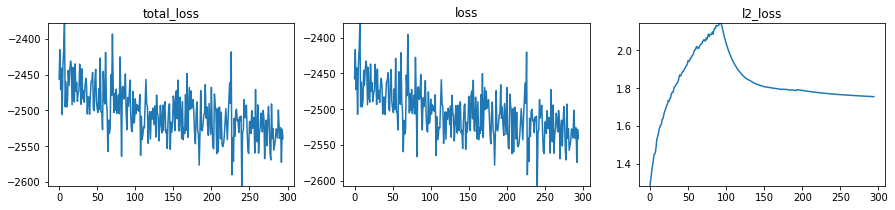

100%|██████████| 10000/10000 [16:23<00:00, 10.17it/s]


In [34]:
utils.trainer(
    sess, 
    num_steps=10000, 
    train_op=train_op, 
    feed_dict_fn=lambda: {lr_ph: 0.0001, beta_ph: 1.}, 
    metrics=[metrics], 
    hooks=[plot_metrics_hook]
)

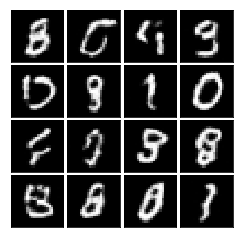

In [44]:
x_samples_np = x_flow_sampled.eval(feed_dict={lr_ph: 0.0, beta_ph: 0.7})
utils.plot_4x4_grid(x_samples_np, shape=x_samples_np.shape[1:3])

### Long train ...

In [ ]:
utils.trainer(
    sess, 
    num_steps=100000, 
    train_op=train_op, 
    feed_dict_fn=lambda: {lr_ph: 0.0001, beta_ph: 1.}, 
    metrics=[metrics], 
    hooks=[plot_metrics_hook]
)

  0%|          | 100/100000 [00:10<2:50:12,  9.78it/s]

total_loss -2515.47
loss -2517.224
l2_loss 1.7541755


  0%|          | 189/100000 [00:19<2:51:03,  9.73it/s]

## Generate samples for different temperatures

We start from zero T i.e. the input standard deviation is zero. We can see simialar 
conclusion as in paper, sampling from reduced temperature yield in better results.

beta=    0.0000


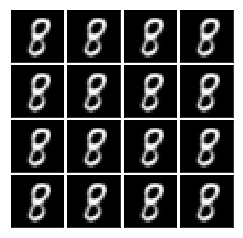

beta=    0.1667


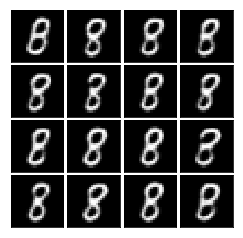

beta=    0.3333


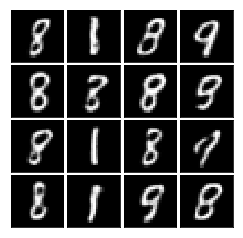

beta=    0.5000


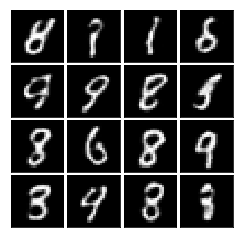

beta=    0.6667


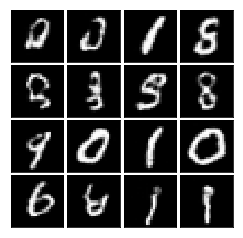

beta=    0.8333


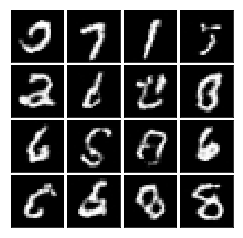

beta=    1.0000


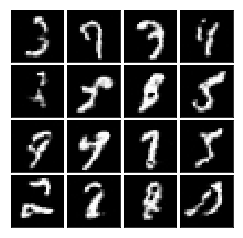

beta=    1.1667


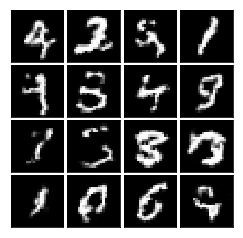

beta=    1.3333


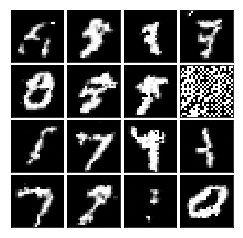

beta=    1.5000


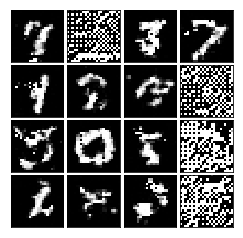

In [105]:
for beta in np.linspace(0.0, 1.5, 10):
    print(f"beta={beta:10.4f}")
    x_samples_np = x_flow_sampled.eval(feed_dict={lr_ph: 0.0, beta_ph: beta})
    utils.plot_4x4_grid(x_samples_np, shape=x_samples_np.shape[1:3])
    plt.show()

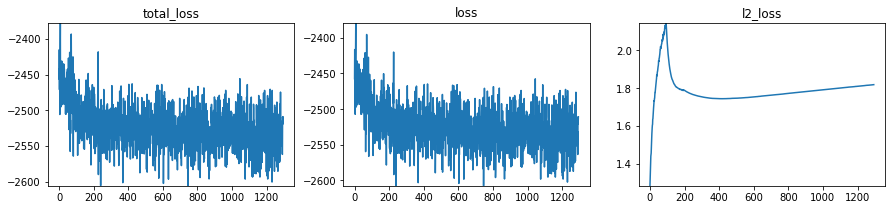

In [70]:
plot_metrics_hook.run()

## Investigate latent space statistics
Check whether the distribution of the latent variables fits the prior distribution. We should observe gaussian

In [79]:
y_flatten_np = np.concatenate([y_flatten.eval({lr_ph: 0.0, beta_ph: 1.0}) for i in range(100)])
y_flatten_np.shape

(3200, 72)

### 2D scatter plot for 0-th and 1-st latent variable

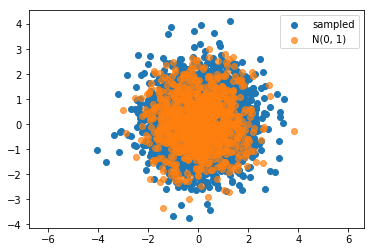

In [89]:
plt.scatter(y_flatten_np[:, 0], y_flatten_np[:, 1], label="sampled")
plt.scatter(*np.random.randn(2, 1000), alpha=0.7, label="N(0, 1)")
plt.axis("equal")
plt.legend()

### Histogram of all activations of Y latent variable

(-4, 4)

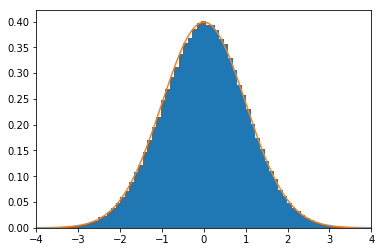

In [101]:
_ = plt.hist(y_flatten_np.reshape([-1]), 100, density=True)
x_axis = np.arange(-4, 4, 0.01)
plt.plot(x_axis, norm.pdf(x_axis, 0, 1))
plt.xlim([-4, 4])

### Histogram of all activations of Z latent variable

In [ ]:
z_flatten_np = np.concatenate([z_flatten.eval({lr_ph: 0.0, beta_ph: 1.0}) for i in range(100)])
_ = plt.hist(z_flatten_np.reshape([-1]), 200, density=True)
x_axis = np.arange(-4, 4, 0.01)
plt.plot(x_axis, norm.pdf(x_axis, 0, 1))
plt.xlim([-4, 4])

## Tuning temperature separatelly for Y and Z latent variables

This seems to generate the best results when the temperature of the distribution of the Z variable is close 
or equal zero. 

In [106]:
beta_y_ph = tf.placeholder(tf.float32, [])
beta_z_ph = tf.placeholder(tf.float32, [])
prior_y_prim = tfd.MultivariateNormalDiag(
    loc=tf.zeros_like(y_flatten), scale_diag=beta_y_ph * tf.ones_like(y_flatten))
prior_z_prim = tfd.MultivariateNormalDiag(
    loc=tf.zeros_like(z_flatten), scale_diag=beta_z_ph * tf.ones_like(z_flatten))

In [107]:
sample_y_flatten_prim = prior_y_prim.sample()
sample_y_prim = tf.reshape(sample_y_flatten_prim, y.shape.as_list())
sample_z_prim = tf.reshape(prior_z_prim.sample(), z.shape.as_list())
sampled_logdet_prim = prior_y_prim.log_prob(sample_y_flatten_prim)

In [108]:
inverse_flow_prim = sample_y_prim, sampled_logdet_prim, sample_z_prim
sampled_flow_prim = model_flow(inverse_flow_prim, forward=False)

FactorOutLayer/Backward/Scale3          : y=[32, 3, 3, 16]	z=[32, 3, 3, 48]	logdet=[32]
AffineCouplingLayer/Backward/           : y=[32, 3, 3, 16]	z=[32, 3, 3, 48]	logdet=[32]
InvertibleConv1x1Layer/Backward/        : y=[32, 3, 3, 16]	z=[32, 3, 3, 48]	logdet=[32]
ActnormScaleLayer/Backward/             : y=[32, 3, 3, 16]	z=[32, 3, 3, 48]	logdet=[32]
ActnormBiasLayer/Backward/              : y=[32, 3, 3, 16]	z=[32, 3, 3, 48]	logdet=[32]
ChainLayer/Backward/                    : y=[32, 3, 3, 16]	z=[32, 3, 3, 48]	logdet=[32]
ActnormLayer/Backward/                  : y=[32, 3, 3, 16]	z=[32, 3, 3, 48]	logdet=[32]
ChainLayer/Backward/Step5               : y=[32, 3, 3, 16]	z=[32, 3, 3, 48]	logdet=[32]
AffineCouplingLayer/Backward/           : y=[32, 3, 3, 16]	z=[32, 3, 3, 48]	logdet=[32]
InvertibleConv1x1Layer/Backward/        : y=[32, 3, 3, 16]	z=[32, 3, 3, 48]	logdet=[32]
ActnormScaleLayer/Backward/             : y=[32, 3, 3, 16]	z=[32, 3, 3, 48]	logdet=[32]
ActnormBiasLayer/Backward/      

In [111]:
x_flow_sampled_prim, _, _ = sampled_flow_prim

### Efect of the temperature on the Z latent variable

beta=    0.0000


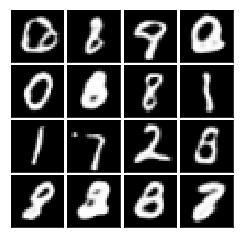

beta=    0.1111


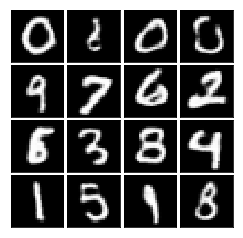

beta=    0.2222


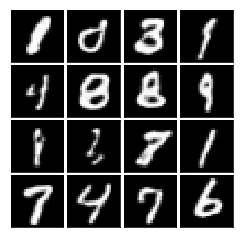

beta=    0.3333


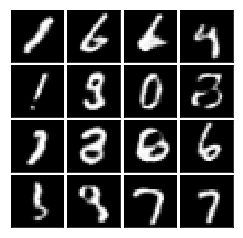

beta=    0.4444


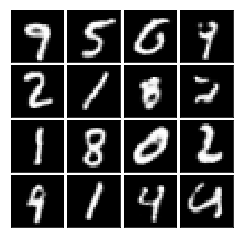

beta=    0.5556


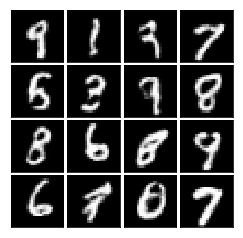

beta=    0.6667


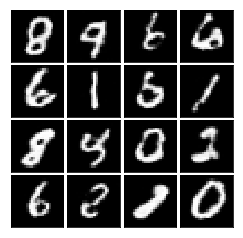

beta=    0.7778


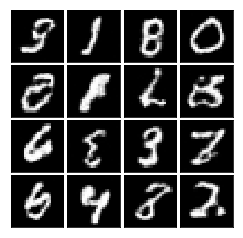

beta=    0.8889


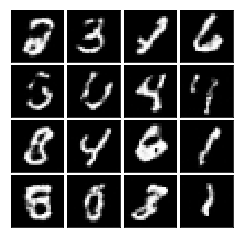

beta=    1.0000


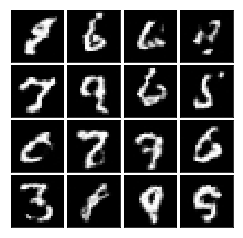

In [122]:
for beta in np.linspace(0.0, 1.0, 10):
    print(f"beta={beta:10.4f}")
    x_samples_np = x_flow_sampled_prim.eval(
        feed_dict={
            lr_ph: 0.0,
            beta_y_ph: 1.0, 
            beta_z_ph: beta
        }
    )
    utils.plot_4x4_grid(x_samples_np, shape=x_samples_np.shape[1:3])
    plt.show()

### Efect of the temperature on the Y latent variable when beta_z=0.1

beta=    0.0000


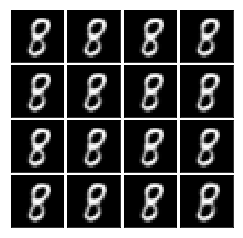

beta=    0.1111


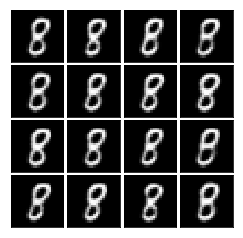

beta=    0.2222


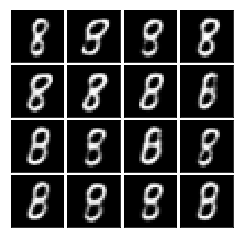

beta=    0.3333


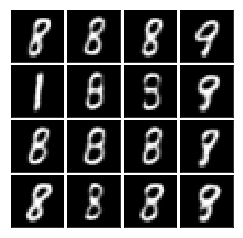

beta=    0.4444


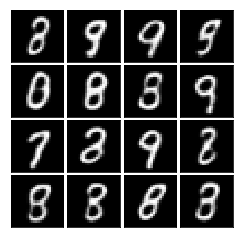

beta=    0.5556


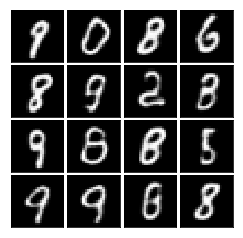

beta=    0.6667


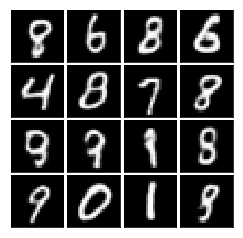

beta=    0.7778


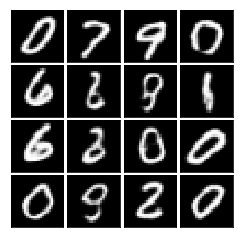

beta=    0.8889


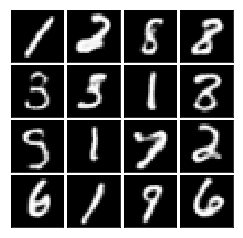

beta=    1.0000


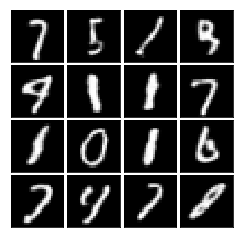

In [123]:
for beta in np.linspace(0.0, 1.0, 10):
    print(f"beta={beta:10.4f}")
    x_samples_np = x_flow_sampled_prim.eval(
        feed_dict={
            lr_ph: 0.0,
            beta_y_ph: beta, 
            beta_z_ph: 0.1
        }
    )
    utils.plot_4x4_grid(x_samples_np, shape=x_samples_np.shape[1:3])
    plt.show()